In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


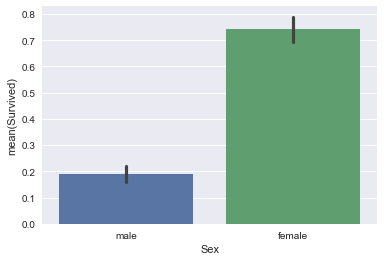

In [88]:
sns.barplot(x="Sex", y="Survived", data=train_data)

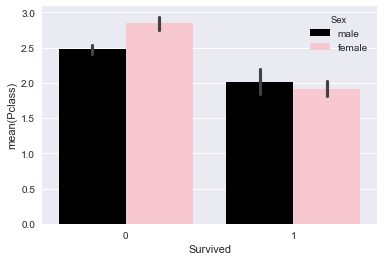

In [89]:
sns.barplot(x='Survived', y='Pclass', hue='Sex', data=train_data, palette={"male": "black", "female": "pink"})

In [90]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

# def simplify_cabins(df):
#     df.Cabin = df.Cabin.fillna('N')
#     df.Cabin = df.Cabin.apply(lambda x: x[0])
#     return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = [0,1,2,3,4]
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

# def format_name(df):
#     df['Lname'] = df.Name.apply(lambda x: x.split(',')[0])
#     df['NamePrefix'] = df.Name.apply(lambda x: x.split(',')[1])
#     return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked', 'Cabin'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
#     df = simplify_cabins(df)
    df = simplify_fares(df)
#     df = format_name(df)
    df = drop_features(df)
    return df

train_data = transform_features(train_data)
test_data = transform_features(test_data)
train_data.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,Student,1,0,1
1,2,1,1,female,Adult,1,0,4
2,3,1,3,female,Young Adult,0,0,1
3,4,1,1,female,Young Adult,1,0,4
4,5,0,3,male,Young Adult,0,0,2
5,6,0,3,male,Unknown,0,0,2
6,7,0,1,male,Adult,0,0,4
7,8,0,3,male,Baby,3,1,3
8,9,1,3,female,Young Adult,0,2,2
9,10,1,2,female,Teenager,1,0,3


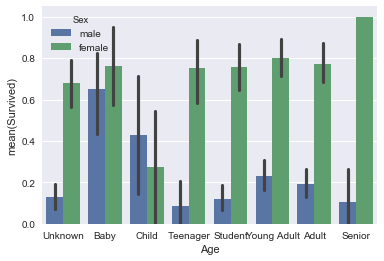

In [91]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=train_data)

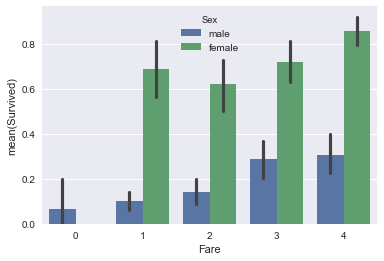

In [92]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=train_data)

In [93]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Age', 'Sex']
#     features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train_data, test_data = encode_features(train_data, test_data)
train_data.head()
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,7,0,0,1
1,893,3,0,0,1,0,1
2,894,2,1,3,0,0,2
3,895,3,1,7,0,0,2
4,896,3,0,4,1,1,2


In [94]:
from sklearn.model_selection import train_test_split

X_all = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_data['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [96]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.810055865922


In [97]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.777777777778
Fold 2 accuracy: 0.876404494382
Fold 3 accuracy: 0.752808988764
Fold 4 accuracy: 0.797752808989
Fold 5 accuracy: 0.85393258427
Fold 6 accuracy: 0.808988764045
Fold 7 accuracy: 0.786516853933
Fold 8 accuracy: 0.719101123596
Fold 9 accuracy: 0.831460674157
Fold 10 accuracy: 0.808988764045
Mean Accuracy: 0.801373283396


In [99]:
ids = test_data['PassengerId']
predictions = clf.predict(test_data.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
